In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/University/Courses/Introduction\ to\ Deep\ Learning/Project\ /Codes/Task1/ObjectDetection/Alexnet_loss
#os.listdir()

/content/drive/My Drive/University/Courses/Introduction to Deep Learning/Project /Codes/Task1/ObjectDetection/Alexnet_loss


**Importing Modules and Libraries**

In [ ]:
import os
import time
import torch
import torchvision
import numpy as np
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from utils import transform
from torch.utils.data import Dataset
from skimage import io 

from PIL import Image


from torch import nn
from utils import *    # make sure utils.py file is in the same directory 
import torch.nn.functional as F
from math import sqrt
from itertools import product as product

import matplotlib.pyplot as plt
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 42


## **Complete Blood Count (CBC) Dataset**

**Custom DataLoader**

In [ ]:
class BCCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, test_size, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        names = [name.replace('.xml','') for name in os.listdir('./'+data_folder+'/Annotations/.') if name.startswith('Blood')]
        self.images_all = []
        self.objects_all = []  
        # Read data files
        
        num_data = len(names)
        indices = list(range(num_data))
        split = int(np.floor(test_size * num_data))

        np.random.seed(random_seed)
        np.random.shuffle(indices)

        train_idx, test_idx = indices[split:], indices[:split]

        if self.split == 'TEST':
            idx = test_idx
        else: 
            idx = train_idx
        
        for id in idx:
            
            with open(os.path.join(data_folder, 'JPEGImages/'+ names[id] + '.jpg'), 'rb') as j:
                image = Image.open(j)
                image = image.convert('RGB')
                self.images_all.append(image)

      
            with open(os.path.join(data_folder, 'Annotations/'+ names[id] + '.xml'), 'rb') as j: #annotation path
                tree = ET.parse(j)
                root = tree.getroot()
                objects = root.findall('object')
                self.objects_all.append(objects)

    def __getitem__(self, i):
        voc_labels = ('WBC', 'RBC', 'Platelets')
        label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
        label_map['background'] = 0
        if torch.is_tensor(i):
            i = i.tolist()

        image = self.images_all[i]
        objects = self.objects_all[i]
        
        # Read objects in this image (bounding boxes, labels, difficulties)
        boxes = []
        labels = []
        difficulties = []
        for obj in objects:    
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            bbox = [xmin, ymin, xmax, ymax]
            boxes.append(bbox)
            
            label = label_map[obj.find('name').text]
            labels.append(label)
            
            diff = int(obj.find('difficult').text)
            difficulties.append(diff)
        
        boxes = torch.FloatTensor(boxes)  # (n_objects, 4)
        labels = torch.as_tensor(labels)  # (n_objects)
        difficulties = torch.ByteTensor(difficulties)  # (n_objects)
        
        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images_all)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [ ]:
# Data Parameters
data_folder = '../../../../Datasets/BCCD/'
keep_difficult = True 
batch_size = 8 
workers = 2

# Training Data
train_dataset = BCCDataset(data_folder,
                           split='train',
                           test_size = 0.25,
                          keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  # note that we're passing the collate function here

print('Size of train data: ', len(train_loader.dataset))

# Testing Data
test_dataset = BCCDataset(data_folder,
                          split='test',
                          test_size = 0.25,
                          keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

print('Size of test data: ', len(test_loader.dataset))

Size of train data:  273
Size of test data:  91


**Example of annotated image in training dataset**

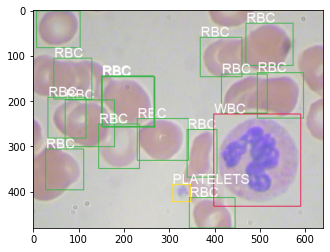

In [ ]:
with open(os.path.join(data_folder, 'JPEGImages/BloodImage_00100.jpg'), 'rb') as j:
      image = Image.open(j)
      image = image.convert('RGB')

with open(os.path.join(data_folder, 'Annotations/BloodImage_00100.xml'), 'rb') as j: #annotation path
      tree = ET.parse(j)
      root = tree.getroot()
      objects = root.findall('object')

voc_labels = ('WBC', 'RBC', 'Platelets')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0

        
# Read objects in this image (bounding boxes, labels, difficulties)
boxes = []
labels = []
difficulties = []
for obj in objects:    
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
            
        bbox = [xmin, ymin, xmax, ymax]
        boxes.append(bbox)
            
        label = obj.find('name').text
        labels.append(label)
            
        diff = int(obj.find('difficult').text)
        difficulties.append(diff)

# Annotate
annotated_image = image
plt.imshow(annotated_image)

draw = ImageDraw.Draw(annotated_image)
font = ImageFont.truetype(font = './Arial.ttf', size = 30)

for i in range(len(boxes)):

        # Boxes
        box_location = boxes[i]
        draw.rectangle(xy=box_location, outline=label_color_map[labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[labels[i]])  

        # Text
        text_size = font.getsize(labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] , box_location[0]  + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[labels[i]])
        draw.text(xy=text_location, text=labels[i].upper(), fill='white',
                  font = font)

plt.imshow(annotated_image)

## **Model: Single Shot Detection(SSD)**

### **Base Model: Alexnet**

In [ ]:
class AlexBase(nn.Module):
    """
    Alexnet base convolutions to produce lower-level feature maps.
    """
    def __init__(self):
        super(AlexBase, self).__init__()

        # Standard convolutional layers in Alexnet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))  # stride = 1, by default
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

        # Replacements for FC6 and FC7 in alexnet
        self.conv6 = nn.Conv2d(256, 1024, kernel_size=3, padding=2, dilation=3)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1, padding=1,)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv7
        """
        out = F.relu(self.conv1(image))  
        out = self.pool1(out) 

        out = F.relu(self.conv2(out))  
        out = self.pool2(out)  

        out = F.relu(self.conv3(out))  

        out = F.relu(self.conv4(out)) 
        conv4_feats = out
        out = F.relu(self.conv5(out))  
        out = self.pool3(out)  
        out = self.conv6(out)
        out = F.relu(out)  
        

        conv7_feats = F.relu(self.conv7(out))  
        # Lower-level feature maps
        return conv4_feats, conv7_feats

    def load_pretrained_layers(self):

        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained Alexnet base
        pretrained_state_dict = torchvision.models.alexnet(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.1.weight'].view(4096, 1024, 3, 3)  
        conv_fc6_bias = pretrained_state_dict['classifier.1.bias']  
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, 4, None, None])  
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4]) 
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.4.weight'].view(4096, 4096, 1, 1)  
        conv_fc7_bias = pretrained_state_dict['classifier.4.bias'] 
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None]) 
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")

In [ ]:
torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
AlexBase()


Loaded base model.



AlexBase(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(3, 3))
  (conv7): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
)

### Auxiliary convolutions

In [ ]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the Alexnet base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=1)  
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) 

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):

        out = F.relu(self.conv8_1(conv7_feats))  
        out = F.relu(self.conv8_2(out))  
        conv8_2_feats = out  

        out = F.relu(self.conv9_1(out))  
        out = F.relu(self.conv9_2(out))  
        conv9_2_feats = out  

        out = F.relu(self.conv10_1(out))  
        out = F.relu(self.conv10_2(out))  
        conv10_2_feats = out  

        out = F.relu(self.conv11_1(out))  
        conv11_2_feats = F.relu(self.conv11_2(out))  
        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


In [ ]:
AuxiliaryConvolutions()

AuxiliaryConvolutions(
  (conv8_1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv8_2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv9_1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv9_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv10_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv10_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv11_1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv11_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Prediction convolutions

In [ ]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4 = nn.Conv2d(256, n_boxes['conv4'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4 = nn.Conv2d(256, n_boxes['conv4'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        
        batch_size = conv4_feats.size(0)

        

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4 = self.loc_conv4(conv4_feats)  
        l_conv4 = l_conv4.permute(0, 2, 3,1).contiguous()  
        
        l_conv4 = l_conv4.view(batch_size, -1, 4)  
        l_conv7 = self.loc_conv7(conv7_feats)  
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  
        l_conv7 = l_conv7.view(batch_size, -1, 4)  

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  

        # Predict classes in localization boxes
        c_conv4 = self.cl_conv4(conv4_feats) 
        c_conv4 = c_conv4.permute(0, 2, 3,
                                      1).contiguous()  
        c_conv4 = c_conv4.view(batch_size, -1, self.n_classes)  

        c_conv7 = self.cl_conv7(conv7_feats)  
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  
        c_conv7 = c_conv7.view(batch_size, -1,self.n_classes)  

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats) 
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes) 

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  

        
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([ l_conv4, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  
        classes_scores = torch.cat([ c_conv4, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],dim=1)  
        return locs, classes_scores


In [ ]:
PredictionConvolutions(3)

PredictionConvolutions(
  (loc_conv4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv7): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv8_2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv9_2): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv10_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv11_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv4): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv7): Conv2d(1024, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv8_2): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv9_2): Conv2d(256, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv10_2): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv11_2): Conv2d(256, 12, kernel_size=(3, 3), stride=

## SSD300 Model

In [ ]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base Alexnet network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = AlexBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 256, 1, 1))  # there are 1024 channels in conv7_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):

        # Run Alexnet base network convolutions (lower level feature map generators)
        conv4_feats, conv7_feats = self.base(image)  

        # Rescale conv4_3 after L2 norm
        norm = conv4_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  
        conv4_feats = conv4_feats / norm  
        conv4_feats = conv4_feats * self.rescale_factors  

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  
        return locs, classes_scores

    def create_prior_boxes(self):

        fmap_dims = {'conv4': 17,
                     'conv7': 8,
                     'conv8_2': 5,
                     'conv9_2': 3,
                     'conv10_2': 1,
                     'conv11_2': 1}

        obj_scales = {'conv4': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  
        prior_boxes.clamp_(0, 1)  

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):

        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1) 

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c] 
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size


### Multibox Loss

In [ ]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):

        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device) 
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior] 
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar



        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  
        conf_loss_neg[positive_priors] = 0.  
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss , conf_loss, loc_loss


## Train

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    loc_losses = AverageMeter()
    conf_losses = AverageMeter()


    start = time.time()

    val_size = 0.2
    indices = list(range(len(train_loader)))
    split = int(np.floor(val_size * len(train_loader)))
    train_idx, val_idx = indices[split:], indices[:split]

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  
        # Loss
        loss, conf_loss , loc_loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        loc_losses.update(loc_loss.item(), images.size(0))
        conf_losses.update(conf_loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} \t'
                  'Data Time {data_time.val:.3f} \t'
                  'Loss {loss.val:.4f} \t'
                  'Location Loss {loc_loss.val:.4f}\t'
                  'Confidence Loss {conf_loss.val:.4f}\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses, 
                                                                 loc_loss= loc_losses, 
                                                                 conf_loss= conf_losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    
    return loss.item(), conf_loss.item() , loc_loss.item()


In [ ]:
# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint_file_name = 'checkpoint_alexnet.pth.tar'
checkpoint = './checkpoint_alexnet.pth.tar'  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 1200  # number of iterations to train
workers = 2  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True



"""
Training.
"""
global start_epoch, label_map, epoch, checkpoint, decay_lr_at

# Initialize model or load checkpoint
if checkpoint is None:
    start_epoch = 0
    model = SSD300(n_classes=n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.Adam(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
    #                            lr=lr, momentum=momentum, weight_decay=weight_decay)
        
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
#    Losses = checkpoint[Losses]

# Move to default device
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    
epochs = iterations // (len(train_dataset) // 32)
decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]
    
print('Number of epochs: ', epochs)
Losses = []
# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate at particular epochs
    if epoch in decay_lr_at:
        adjust_learning_rate(optimizer, decay_lr_to)

    # One epoch's training
    Losses.append(train(train_loader=train_loader,
                        model=model,
                        criterion=criterion,
                        optimizer=optimizer,
                        epoch=epoch))

        # Save checkpoint
    save_checkpoint(epoch, model, optimizer, checkpoint_file_name)





Loaded checkpoint from epoch 150.

Number of epochs:  150


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
from utils import *

from tqdm import tqdm
from pprint import PrettyPrinter

# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

batch_size = 8
workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = './checkpoint_alexnet.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()




def evaluate(loader, model):
    """
    Evaluate.
    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py
    losses = []
    loc_losses = []
    conf_losses = []
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(loader, desc='Evaluating')):
            
            print(i)
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            # Loss
            loss, conf_loss , loc_loss = criterion(predicted_locs, predicted_scores, boxes, labels)
            losses.append(loss.item())
            loc_losses.append(loc_loss.item())
            conf_losses.append(conf_loss.item())
            
            print(str(i) + ': ',loss.item())
            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        Recalls, Precisions, ARs, APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    print('Average Precisions: ')
    pp.pprint(APs)
    print('Average Recalls: ')
    pp.pprint(ARs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)
    return losses , loc_losses, conf_losses,  Recalls, Precisions



In [ ]:
train_loss, loc_losses, conf_losses, Recalls, Precisions = evaluate(train_loader, model)


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
Evaluating:   3%|▎         | 1/35 [00:02<01:30,  2.67s/it]

0:  3.4448814392089844
1


Evaluating:   6%|▌         | 2/35 [00:03<01:12,  2.20s/it]

1:  3.504737377166748
2


Evaluating:   9%|▊         | 3/35 [00:04<00:59,  1.86s/it]

2:  3.205226182937622
3


Evaluating:  11%|█▏        | 4/35 [00:06<00:51,  1.67s/it]

3:  3.112649440765381
4


Evaluating:  14%|█▍        | 5/35 [00:07<00:45,  1.51s/it]

4:  3.0431454181671143
5


Evaluating:  17%|█▋        | 6/35 [00:08<00:40,  1.40s/it]

5:  3.1695172786712646
6


Evaluating:  20%|██        | 7/35 [00:09<00:36,  1.30s/it]

6:  2.9847118854522705
7


Evaluating:  23%|██▎       | 8/35 [00:10<00:34,  1.26s/it]

7:  3.3022546768188477
8


Evaluating:  26%|██▌       | 9/35 [00:11<00:32,  1.24s/it]

8:  3.3275606632232666
9


Evaluating:  29%|██▊       | 10/35 [00:12<00:29,  1.20s/it]

9:  3.4416370391845703
10


Evaluating:  31%|███▏      | 11/35 [00:13<00:28,  1.18s/it]

10:  3.106698989868164
11


Evaluating:  34%|███▍      | 12/35 [00:15<00:27,  1.19s/it]

11:  3.2210946083068848
12


Evaluating:  37%|███▋      | 13/35 [00:16<00:25,  1.15s/it]

12:  2.9035110473632812
13


Evaluating:  40%|████      | 14/35 [00:17<00:23,  1.13s/it]

13:  3.2158334255218506
14


Evaluating:  43%|████▎     | 15/35 [00:18<00:22,  1.12s/it]

14:  3.2334697246551514
15


Evaluating:  46%|████▌     | 16/35 [00:19<00:22,  1.16s/it]

15:  3.450596809387207
16


Evaluating:  49%|████▊     | 17/35 [00:20<00:20,  1.16s/it]

16:  3.1071791648864746
17


Evaluating:  51%|█████▏    | 18/35 [00:22<00:19,  1.15s/it]

17:  3.010098695755005
18


Evaluating:  54%|█████▍    | 19/35 [00:23<00:18,  1.15s/it]

18:  inf
19


Evaluating:  57%|█████▋    | 20/35 [00:24<00:17,  1.14s/it]

19:  3.2154793739318848
20


Evaluating:  60%|██████    | 21/35 [00:25<00:15,  1.13s/it]

20:  3.0471115112304688
21


Evaluating:  63%|██████▎   | 22/35 [00:26<00:14,  1.15s/it]

21:  3.3967881202697754
22


Evaluating:  66%|██████▌   | 23/35 [00:27<00:13,  1.14s/it]

22:  3.231451988220215
23


Evaluating:  69%|██████▊   | 24/35 [00:28<00:12,  1.14s/it]

23:  3.113826036453247
24


Evaluating:  71%|███████▏  | 25/35 [00:30<00:11,  1.15s/it]

24:  3.126744270324707
25


Evaluating:  74%|███████▍  | 26/35 [00:31<00:10,  1.17s/it]

25:  3.2247862815856934
26


Evaluating:  77%|███████▋  | 27/35 [00:32<00:09,  1.14s/it]

26:  3.10294246673584
27


Evaluating:  80%|████████  | 28/35 [00:33<00:08,  1.16s/it]

27:  3.5373592376708984
28


Evaluating:  83%|████████▎ | 29/35 [00:34<00:06,  1.15s/it]

28:  3.236037015914917
29


Evaluating:  86%|████████▌ | 30/35 [00:35<00:05,  1.15s/it]

29:  3.306972026824951
30


Evaluating:  89%|████████▊ | 31/35 [00:36<00:04,  1.08s/it]

30:  3.0185272693634033
31


Evaluating:  91%|█████████▏| 32/35 [00:37<00:03,  1.04s/it]

31:  3.3261356353759766
32


Evaluating:  94%|█████████▍| 33/35 [00:38<00:02,  1.00s/it]

32:  3.2978928089141846
33


Evaluating:  97%|█████████▋| 34/35 [00:39<00:00,  1.03it/s]

33:  3.189528226852417
34


Evaluating: 100%|██████████| 35/35 [00:39<00:00,  1.14s/it]

34:  3.0707855224609375


Average Precisions: 
{'Platelets': 0.10900591313838959,
 'RBC': 0.3738934099674225,
 'WBC': 0.7335538864135742}
Average Recalls: 
{'Platelets': 0.12479828298091888,
 'RBC': 0.5457215309143066,
 'WBC': 0.6760401129722595}

Mean Average Precision (mAP): 0.405


In [ ]:
test_loss, loc_losses, conf_losses, Recalls, Precisions = evaluate(test_loader, model)


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
Evaluating:   8%|▊         | 1/12 [00:01<00:12,  1.16s/it]

0:  3.1105268001556396
1


Evaluating:  17%|█▋        | 2/12 [00:02<00:10,  1.08s/it]

1:  2.993103265762329
2


Evaluating:  25%|██▌       | 3/12 [00:02<00:09,  1.02s/it]

2:  3.0997824668884277
3


Evaluating:  33%|███▎      | 4/12 [00:03<00:07,  1.02it/s]

3:  2.9768123626708984
4


Evaluating:  42%|████▏     | 5/12 [00:04<00:06,  1.04it/s]

4:  3.009316921234131
5


Evaluating:  50%|█████     | 6/12 [00:05<00:05,  1.07it/s]

5:  2.9798312187194824
6


Evaluating:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s]

6:  2.9111483097076416
7


Evaluating:  67%|██████▋   | 8/12 [00:07<00:03,  1.11it/s]

7:  3.0120837688446045
8


Evaluating:  75%|███████▌  | 9/12 [00:08<00:02,  1.13it/s]

8:  3.1059205532073975
9


Evaluating:  83%|████████▎ | 10/12 [00:09<00:01,  1.15it/s]

9:  inf
10


Evaluating:  92%|█████████▏| 11/12 [00:09<00:00,  1.16it/s]

10:  3.012861967086792
11


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

11:  2.917314052581787


Average Precisions: 
{'Platelets': 0.1470545530319214,
 'RBC': 0.6873225569725037,
 'WBC': 0.8955086469650269}
Average Recalls: 
{'Platelets': 0.3018534779548645,
 'RBC': 0.8788996934890747,
 'WBC': 0.8406647443771362}

Mean Average Precision (mAP): 0.577


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = './checkpoint_alexnet.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    plt.imshow(annotated_image)
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype(font = './Arial.ttf', size = 30)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] , box_location[0]  + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font = font)
    #del draw
    plt.imshow(annotated_image)
    return annotated_image




Loaded checkpoint from epoch 150.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


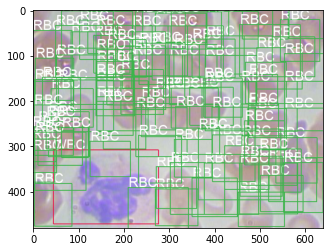

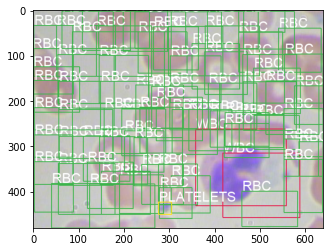

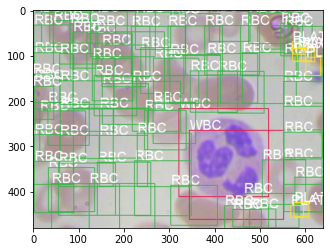

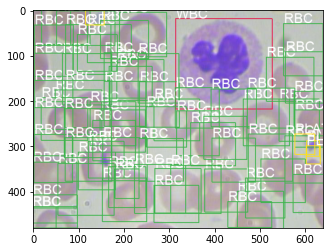

In [ ]:
for id in ['001', '101', '201', '301']: 
    fig, ax = plt.subplots()
    img_path = '../../../../Datasets/BCCD/JPEGImages/BloodImage_00'+id+'.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    annotated_image = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)

    ax.imshow(annotated_image)
    plt.savefig('AnnotatedImage'+id+'.png')